In [62]:
from collections import defaultdict, Counter
import json
import glob
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cityblock
from scipy.stats import pearsonr, shapiro
from scipy.linalg import expm

from utils import (
    prepare_exp_aa_subst, amino_acid_codes,
    get_equilibrium_freqs, get_equilibrium_probabilities,
    prepare_exp_cdn_subst,
)

## Prepare data

### Load ref

In [63]:
amino_acid_codes_rev = {v: k for k, v in amino_acid_codes.items()}

In [64]:
with open('./data/ref_aa_freqs_mean.json') as f:
    aa_freqs_total_dct_ref = json.load(f)
aa_freqs_total_dct_ref = {amino_acid_codes_rev[k]: v for k, v in aa_freqs_total_dct_ref.items()}
aa_freqs_total_dct_ref

{'R': 350,
 'V': 782,
 'C': 296,
 'G': 577,
 'S': 661,
 'A': 659,
 'L': 930,
 'T': 718,
 'P': 394,
 'D': 511,
 'Y': 448,
 'F': 501,
 'I': 513,
 'N': 532,
 'K': 562,
 'Q': 365,
 'E': 442,
 'H': 189,
 'M': 207,
 'W': 111}

### Load genotypes from 2025

In [65]:
paths = glob.glob('./data/genotypes2025/gisaid_*.tsv')
paths

['./data/genotypes2025/gisaid_hcov-19_2025_05_29_10(5).tsv',
 './data/genotypes2025/gisaid_hcov-19_2025_05_29_10(4).tsv',
 './data/genotypes2025/gisaid_hcov-19_2025_05_29_10(3).tsv',
 './data/genotypes2025/gisaid_hcov-19_2025_05_29_10(7).tsv',
 './data/genotypes2025/gisaid_hcov-19_2025_05_29_10(6).tsv',
 './data/genotypes2025/gisaid_hcov-19_2025_05_29_10(2).tsv',
 './data/genotypes2025/gisaid_hcov-19_2025_05_29_10(1).tsv']

In [66]:
genotypes = pd.concat([pd.read_csv(paths[i], sep='\t', index_col=1) for i in range(len(paths))])
print(genotypes.shape)
genotypes.head(2)

(59916, 15)


,Virus name,Collection date,Location,Host,Passage,Specimen,Additional host information,Sampling strategy,Sequencing technology,Assembly method,Comment,Comment type,Lineage,Clade,AA Substitutions
Accession ID,,,,,,,,,,,,,,,
EPI_ISL_19763788,hCoV-19/Japan/FR084-0021/2025,2025-01-31,Asia / Japan / Saitama,Human,Original,NaN,NaN,NaN,Illumina iSeq,NaN,Insertion of 12 nucleotides when compared to t...,warn,XEC (consensus call),GRA,"(NSP5_P132H,Spike_H69del,NSP3_G489S,Spike_L24d..."
EPI_ISL_19763878,hCoV-19/Japan/FR084-0031/2025,2025-01-30,Asia / Japan / Saitama,Human,Original,NaN,NaN,NaN,Illumina iSeq,NaN,Gap of 68 nucleotides when compared to the ref...,warn,XEC,GRA,"(NSP5_P132H,Spike_H69del,NSP3_G489S,Spike_L24d..."


In [67]:
genotypes.Host.value_counts()

Host
Human    59916
Name: count, dtype: int64

In [68]:
genotypes.Passage.value_counts()

Passage
Original              59862
Culture passage 0        46
Vero E6, P2               3
Vero E6/TMPRSS2 P0        2
Vero E6/TMPRSS2 P1        2
Vero E6 P2                1
Name: count, dtype: int64

In [69]:
genotypes['Lineage'].value_counts().head(10)

Lineage
XEC (consensus call)          13887
LP.8.1.1 (consensus call)      5829
KP.3.1.1 (consensus call)      2868
LP.8.1 (consensus call)        2600
MC.1 (consensus call)          1380
XEC                            1366
JN.1.11 (consensus call)       1175
JN.1.16.1 (consensus call)     1160
XEC.4 (consensus call)         1111
XEC.2 (consensus call)         1060
Name: count, dtype: int64

In [70]:
genotypes['Clade'].value_counts()

Clade
GRA    59414
GR       490
G          5
O          2
GK         1
Name: count, dtype: int64

In [71]:
genotypes['Collection date'].agg(['min', 'max'])

min    2025-01-01
max    2025-05-22
Name: Collection date, dtype: object

In [72]:
genotypes = genotypes.query('Clade == "GRA" & Passage == "Original"')
genotypes.shape

(59361, 15)

In [12]:
genotypes.index.to_series().to_csv('./data/genotypes2025/AccessionIDs.tsv', 
                                   sep='\t', index=False, header=False)

In [13]:
# Mutability of proteins

genotypes['AA Substitutions'].apply(
    lambda x: pd.Series(Counter([y.split('_')[0] for y in x.strip('()').split(',')])))\
        .mean(0).sort_values(ascending=False)

Spike    65.118175
N         8.079766
NSP3      7.521875
NSP6      4.977307
M         4.959254
NSP4      3.103341
NSP2      1.541883
NS3       1.521179
NS6       1.431631
NS7a      1.346249
NSP1      1.317833
NS8       1.229696
NSP12     1.181781
NSP14     1.167849
NSP13     1.130279
NSP15     1.086080
NSP5      1.076391
NSP16     1.060511
NSP9      1.045010
NSP8      1.037418
NSP7      1.027287
NSP10     1.021456
NS7b      1.018954
E         1.007606
dtype: float64

In [73]:
def collect_difference(aa_sbs: str, use_genes=None):
    use_genes = set(use_genes) if use_genes is not None else None

    aa_content_delta = defaultdict(int)

    for x in aa_sbs.strip('()').split(','):
        gene,mut = x.split('_')
        m = bool(re.match(r'^[A-Z]\d+[A-Z]$', mut))
        if m:
            if use_genes is not None and gene not in use_genes:
                continue
            aa1, aa2 = mut[0], mut[-1]
            aa_content_delta[aa1] -= 1
            aa_content_delta[aa2] += 1

        elif not m and not mut.endswith('del') and not mut.startswith('ins') and not mut.endswith('stop'):
            print('WARNING:', gene, mut, x)
    
    return pd.Series(aa_content_delta)

In [74]:
aa_delta = genotypes['AA Substitutions'].apply(collect_difference).fillna(0.)
aa_delta

,P,H,G,S,T,I,E,K,Y,N,...,L,F,D,V,C,W,M,Z,J,B
Accession ID,,,,,,,,,,,,,,,,,,,,,
EPI_ISL_19763788,-3.0,4.0,-2.0,1.0,-7.0,7.0,0.0,10.0,2.0,-3.0,...,4.0,2.0,-1.0,-3.0,1.0,1.0,0.0,0.0,0.0,0.0
EPI_ISL_19763878,-3.0,4.0,-2.0,1.0,-7.0,7.0,0.0,10.0,2.0,-4.0,...,3.0,2.0,0.0,-2.0,1.0,1.0,0.0,0.0,0.0,0.0
EPI_ISL_19764060,-5.0,3.0,-2.0,1.0,-9.0,10.0,0.0,9.0,2.0,-5.0,...,4.0,3.0,0.0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0
EPI_ISL_19766525,-3.0,4.0,-2.0,0.0,-7.0,7.0,0.0,10.0,2.0,-4.0,...,4.0,2.0,0.0,-2.0,1.0,1.0,0.0,0.0,0.0,0.0
EPI_ISL_19763886,-3.0,4.0,-2.0,1.0,-9.0,8.0,0.0,10.0,2.0,-4.0,...,2.0,3.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EPI_ISL_19885825,-3.0,3.0,-2.0,-1.0,-6.0,7.0,0.0,8.0,2.0,-5.0,...,3.0,3.0,1.0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0
EPI_ISL_19885820,-5.0,3.0,-2.0,0.0,-7.0,8.0,0.0,8.0,2.0,-5.0,...,5.0,3.0,0.0,1.0,1.0,1.0,-1.0,0.0,0.0,0.0
EPI_ISL_19885830,-6.0,3.0,-2.0,2.0,-7.0,8.0,0.0,8.0,2.0,-5.0,...,4.0,3.0,0.0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [16]:
# mean change
aa_delta.fillna(0).mean(0).sort_values(ascending=False)

K    9.069878
I    7.955661
H    3.654824
L    3.454120
F    2.753070
Y    2.089773
C    1.223750
W    0.941763
S    0.329594
B    0.002780
J    0.002072
Z    0.002038
M   -0.026212
D   -0.110898
E   -0.165092
R   -1.181887
V   -1.266000
G   -2.053385
P   -3.926703
N   -4.273782
Q   -4.848048
A   -5.928556
T   -7.698758
dtype: float64

### All proteins ???

In [75]:
aa_content_full = aa_delta.drop(['J', 'B', 'Z'], axis=1).fillna(0) + aa_freqs_total_dct_ref
aa_content_full

,P,H,G,S,T,I,E,K,Y,N,R,A,Q,L,F,D,V,C,W,M
Accession ID,,,,,,,,,,,,,,,,,,,,
EPI_ISL_19763788,391.0,193.0,575.0,662.0,711.0,520.0,442.0,572.0,450.0,529.0,348.0,653.0,360.0,934.0,503.0,510.0,779.0,297.0,112.0,207.0
EPI_ISL_19763878,391.0,193.0,575.0,662.0,711.0,520.0,442.0,572.0,450.0,528.0,348.0,653.0,360.0,933.0,503.0,511.0,780.0,297.0,112.0,207.0
EPI_ISL_19764060,389.0,192.0,575.0,662.0,709.0,523.0,442.0,571.0,450.0,527.0,349.0,653.0,360.0,934.0,504.0,511.0,781.0,297.0,112.0,207.0
EPI_ISL_19766525,391.0,193.0,575.0,661.0,711.0,520.0,442.0,572.0,450.0,528.0,348.0,653.0,360.0,934.0,503.0,511.0,780.0,297.0,112.0,207.0
EPI_ISL_19763886,391.0,193.0,575.0,662.0,709.0,521.0,442.0,572.0,450.0,528.0,348.0,651.0,360.0,932.0,504.0,511.0,783.0,297.0,112.0,207.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EPI_ISL_19885825,391.0,192.0,575.0,660.0,712.0,520.0,442.0,570.0,450.0,527.0,350.0,653.0,360.0,933.0,504.0,512.0,781.0,297.0,112.0,207.0
EPI_ISL_19885820,389.0,192.0,575.0,661.0,711.0,521.0,442.0,570.0,450.0,527.0,350.0,652.0,360.0,935.0,504.0,511.0,783.0,297.0,112.0,206.0
EPI_ISL_19885830,388.0,192.0,575.0,663.0,711.0,521.0,442.0,570.0,450.0,527.0,350.0,653.0,360.0,934.0,504.0,511.0,781.0,297.0,112.0,207.0


In [11]:
aa_content_full.sum(1)

Accession ID
EPI_ISL_19763788    9748.0
EPI_ISL_19763878    9748.0
EPI_ISL_19764060    9748.0
EPI_ISL_19766525    9748.0
EPI_ISL_19763886    9748.0
                     ...  
EPI_ISL_19885825    9748.0
EPI_ISL_19885820    9748.0
EPI_ISL_19885830    9748.0
EPI_ISL_19885805    9748.0
EPI_ISL_19881199    9748.0
Length: 59361, dtype: float64

In [19]:
sum(aa_freqs_total_dct_ref.values())

9748

In [76]:
aa_eq_freqs_20A = pd.read_csv('./data/20A/aa_eq_freqs.csv', index_col=0)
aa_eq_freqs_20A['eq_freq'] = aa_eq_freqs_20A['eq_freq'] * sum(aa_freqs_total_dct_ref.values())
aa_eq_freqs_20A

,eq_freq
aa,
Phe,3067.081476
Leu,1928.398100
Ser,1162.751188
Ile,847.083654
Tyr,717.832972
Val,430.516521
Cys,343.934785
Thr,246.201337
His,196.744859


In [21]:
aa_content_full.rename(columns=amino_acid_codes).to_csv('./data/aa_content_2025.csv')

In [69]:
aa_content_full.mean(0).rename('gisaid_2025')\
    .rename(index=amino_acid_codes).to_csv('./data/mean_aa_content_2025.csv', header=False)

## Compare expected and observed freq changes

In [77]:
def get_random_rate_matrix(n=20):
    """
    Generates a valid random 20x20 Q-matrix (infinitesimal generator).
    - Off-diagonals >= 0
    - Row sums = 0
    """
    # Create random matrix with positive values
    M = np.random.rand(n, n)
    
    # Zero out the diagonal initially
    np.fill_diagonal(M, 0)
    
    # Calculate row sums (off-diagonal sums)
    row_sums = M.sum(axis=1)
    
    # Set diagonal to negative of row sums to satisfy Q-matrix property
    # Q_ii = -sum(Q_ij for j != i)
    np.fill_diagonal(M, -row_sums)
    
    return M


def simulate_euler_method(Q, initial_vector, total_time, delta_t=0.01):
    """
    Forward Euler integration.
    Solves d(pi)/dt = pi * Q
    """
    pi = initial_vector.copy()
    times = [0]
    data = [pi.copy()]
    
    current_time = 0
    num_steps = int(total_time / delta_t)
    
    for _ in range(num_steps):
        # Euler step: pi(t+dt) = pi(t) + pi(t) @ Q * dt
        delta_pi = (pi @ Q) * delta_t
        pi_new = pi + delta_pi
        
        # Enforce non-negativity (Euler can overshoot into negatives)
        pi_new[pi_new < 0] = 0
        
        # Renormalize (Standard practice in numerical integration of probabilities)
        pi_new = pi_new / pi_new.sum()
        
        pi = pi_new
        current_time += delta_t
        
        times.append(current_time)
        data.append(pi.copy())
        
    return np.array(times), np.array(data)


def simulate_exact_method(Q, initial_vector, total_time, steps=100):
    """
    The 'Gold Standard' approach: Matrix Exponentiation.
    Solves pi(t) = pi(0) * e^(Qt)
    """
    times = np.linspace(0, total_time, steps)
    data = []
    
    # We can compute P(t) = e^(Qt)
    # Since pi(t) = pi(0) @ P(t)
    
    for t in times:
        if t == 0:
            data.append(initial_vector)
            continue
            
        # Compute transition matrix P for time t exactly
        P_t = expm(Q * t)
        
        pi_t = initial_vector @ P_t
        data.append(pi_t)
        
    return times, np.array(data)

In [78]:
clades_spectra = pd.read_csv('data/bloom_etal/rates_by_clade.csv').query('subset == "all"')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_20A

,subset,clade,mut_type,count,total_count,fraction,parent_nt,parent_nt_frac,rate,Mut
0,all,20A,AtoC,305,18970,0.016078,A,0.289560,0.007540,A>C
1,all,20A,AtoG,1778,18970,0.093727,A,0.289560,0.043953,A>G
2,all,20A,AtoT,588,18970,0.030996,A,0.289560,0.014536,A>T
3,all,20A,CtoA,384,18970,0.020242,C,0.135130,0.020341,C>A
4,all,20A,CtoG,135,18970,0.007117,C,0.135130,0.007151,C>G
5,all,20A,CtoT,7840,18970,0.413280,C,0.135130,0.415293,C>T
6,all,20A,GtoA,878,18970,0.046284,G,0.064585,0.097310,G>A
7,all,20A,GtoC,140,18970,0.007380,G,0.064585,0.015516,G>C
8,all,20A,GtoT,2906,18970,0.153190,G,0.064585,0.322075,G>T
9,all,20A,TtoA,639,18970,0.033685,T,0.510720,0.008956,T>A


In [79]:
_, Maa = prepare_exp_aa_subst(spectrum_20A)
Maa = (Maa.T / Maa.sum(axis=1)).T
Maa

aa2,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Trp,Tyr,Val
aa1,,,,,,,,,,,,,,,,,,,,
Ala,0.221693,0.000000,0.000000,0.009019,0.000000,0.000000,0.009019,0.006342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013760,0.285607,0.086291,0.000000,0.000000,0.368270
Arg,0.000000,0.214378,0.000000,0.000000,0.148752,0.034855,0.000000,0.020866,0.034855,0.057681,0.230725,0.034855,0.057681,0.000000,0.011116,0.071700,0.005558,0.076979,0.000000,0.000000
Asn,0.000000,0.000000,0.597633,0.115183,0.000000,0.000000,0.000000,0.000000,0.019758,0.038093,0.000000,0.056297,0.000000,0.000000,0.000000,0.115183,0.019758,0.000000,0.038093,0.000000
Asp,0.010047,0.000000,0.129666,0.303882,0.000000,0.000000,0.028626,0.058568,0.020676,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.429167,0.019369
Cys,0.000000,0.056210,0.000000,0.000000,0.314091,0.000000,0.000000,0.008976,0.000000,0.000000,0.000000,0.000000,0.000000,0.443585,0.000000,0.033705,0.000000,0.009413,0.134022,0.000000
Gln,0.000000,0.127776,0.000000,0.000000,0.000000,0.205332,0.020789,0.000000,0.522793,0.000000,0.042258,0.059133,0.000000,0.000000,0.021918,0.000000,0.000000,0.000000,0.000000,0.000000
Glu,0.017562,0.000000,0.000000,0.418880,0.000000,0.036142,0.164519,0.102379,0.000000,0.000000,0.000000,0.226660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033858
Gly,0.014930,0.061746,0.000000,0.046816,0.154950,0.000000,0.046816,0.240551,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046816,0.000000,0.077475,0.000000,0.309901
His,0.000000,0.057959,0.026823,0.009430,0.000000,0.028328,0.000000,0.000000,0.300722,0.000000,0.019168,0.000000,0.000000,0.000000,0.009942,0.000000,0.000000,0.000000,0.547628,0.000000


In [80]:
_, Mcdn = prepare_exp_cdn_subst(spectrum_20A)
Mcdn = (Mcdn.T / Mcdn.sum(axis=1)).T
Mcdn

cdn2,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
cdn1,,,,,,,,,,,,,,,,,,,,,
AAA,0.000000,0.038062,0.221889,0.073382,0.038062,0.000000,0.000000,0.000000,0.221889,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AAC,0.035385,0.000000,0.012440,0.722446,0.000000,0.013116,0.000000,0.000000,0.000000,0.076461,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AAG,0.171634,0.027368,0.000000,0.568075,0.000000,0.000000,0.013298,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AAT,0.047551,0.216692,0.034602,0.000000,0.000000,0.000000,0.000000,0.040031,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ACA,0.035385,0.000000,0.000000,0.000000,0.000000,0.013116,0.076461,0.025287,0.012440,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.028342,0.016359,0.074547,0.011904,0.000000,0.000000,0.000000,0.000000,0.588295
TTA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.036490,0.000000,0.000000,0.000000,0.000000,0.042215,0.246099,0.081389
TTC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.011735,0.000000,0.000000,0.036627,0.000000,0.012877,0.747796


In [81]:
# TODO replace by direct aa content parsing
# ref_aa_freqs_mean.json

aa_content_ref = {'Met': 207,
 'Glu': 442,
 'Ser': 661,
 'Leu': 930,
 'Val': 781,
 'Pro': 394,
 'Gly': 576,
 'Phe': 500,
 'Asn': 532,
 'Lys': 562,
 'Thr': 718,
 'His': 189,
 'Gln': 365,
 'Arg': 350,
 'Asp': 511,
 'Ala': 658,
 'Cys': 296,
 'Tyr': 448,
 'Ile': 513,
 'Trp': 111}

aa_init_freqs = np.array([aa_content_ref[x] for x in Maa.columns])
aa_init_freqs = aa_init_freqs / aa_init_freqs.sum()
aa_init_freqs

array([0.06752874, 0.03591954, 0.0545977 , 0.05244253, 0.03037767,
       0.03745895, 0.04536125, 0.0591133 , 0.01939655, 0.05264778,
       0.09544335, 0.05767652, 0.02124384, 0.05131363, 0.04043514,
       0.06783662, 0.07368637, 0.01139163, 0.04597701, 0.08015189])

In [82]:
aa_content25total = pd.read_csv('./data/aa_content_2025.csv', index_col=0)
aa_content25total_freqs = (aa_content25total.T / aa_content25total.sum(axis=1)).T

df_change_total = aa_content25total_freqs\
    .melt(ignore_index=False, value_name='gisaid25', var_name='aa')

df_change_total['refseq'] = df_change_total['aa'].map(aa_content_ref) / sum(aa_content_ref.values())

df_change_total['obs_change'] = df_change_total['gisaid25'] - df_change_total['refseq']
df_change_total['PE_obs'] = df_change_total['obs_change'] / df_change_total['refseq']*100

df_change_total

,aa,gisaid25,refseq,obs_change,PE_obs
Accession ID,,,,,
EPI_ISL_19763788,Pro,0.040111,0.040435,-0.000324,-0.802143
EPI_ISL_19763878,Pro,0.040111,0.040435,-0.000324,-0.802143
EPI_ISL_19764060,Pro,0.039906,0.040435,-0.000530,-1.309549
EPI_ISL_19766525,Pro,0.040111,0.040435,-0.000324,-0.802143
EPI_ISL_19763886,Pro,0.040111,0.040435,-0.000324,-0.802143
...,...,...,...,...,...
EPI_ISL_19885825,Met,0.021235,0.021244,-0.000009,-0.041034
EPI_ISL_19885820,Met,0.021133,0.021244,-0.000111,-0.523928
EPI_ISL_19885830,Met,0.021235,0.021244,-0.000009,-0.041034


In [83]:
mean_obs_change = df_change_total['obs_change'].abs().groupby('Accession ID').sum().mean()
mean_obs_change

np.float64(0.006509319997128249)

In [84]:
Q = Maa.copy()
Q = Q - np.diag(np.sum(Q, axis=1))

T_max = 0.02

# Run Simulations
t_exact, sim_freqs = simulate_exact_method(Q, aa_init_freqs, T_max, steps=100)

for i, f in enumerate(sim_freqs):
    sim_change = cityblock(f, aa_init_freqs)
    if sim_change >= mean_obs_change:
        print(i, mean_obs_change, sim_change)
        break

closest_sim_freqs_dct = dict(zip(Maa.columns, sim_freqs[i]))
sim_freqs[i]

73 0.006509319997128249 0.0065193131709168975


array([0.06692699, 0.03582331, 0.05488574, 0.05234881, 0.03046939,
       0.03710224, 0.0449961 , 0.0586205 , 0.01962459, 0.05336582,
       0.09590127, 0.05726613, 0.02122449, 0.05218081, 0.04011618,
       0.06802189, 0.07323308, 0.01134031, 0.04634746, 0.08020488])

In [85]:
df_change_total['sim'] = df_change_total['aa'].map(closest_sim_freqs_dct)
df_change_total['exp_change'] = df_change_total['sim'] - df_change_total['refseq']
df_change_total['PE_exp'] = df_change_total['exp_change'] / df_change_total['refseq']*100
df_change_total.head()

,aa,gisaid25,refseq,obs_change,PE_obs,sim,exp_change,PE_exp
Accession ID,,,,,,,,
EPI_ISL_19763788,Pro,0.040111,0.040435,-0.000324,-0.802143,0.040116,-0.000319,-0.788811
EPI_ISL_19763878,Pro,0.040111,0.040435,-0.000324,-0.802143,0.040116,-0.000319,-0.788811
EPI_ISL_19764060,Pro,0.039906,0.040435,-0.000530,-1.309549,0.040116,-0.000319,-0.788811
EPI_ISL_19766525,Pro,0.040111,0.040435,-0.000324,-0.802143,0.040116,-0.000319,-0.788811
EPI_ISL_19763886,Pro,0.040111,0.040435,-0.000324,-0.802143,0.040116,-0.000319,-0.788811


In [86]:
# used for visualization
quantiles = df_change_total.groupby('aa')[['PE_exp', 'PE_obs']].quantile([0.25, 0.5, 0.75])
quantiles.index.names = ['aa', 'quantile']
quantiles = quantiles.reset_index()
quantiles.head()

,aa,quantile,PE_exp,PE_obs
0,Ala,0.25,-0.891095,-0.800601
1,Ala,0.50,-0.891095,-0.800601
2,Ala,0.75,-0.891095,-0.648687
3,Arg,0.25,-0.267897,-0.612228
4,Arg,0.50,-0.267897,-0.326631


In [87]:
losers = []
gainers = ['Ser', 'Leu', 'His', 'Ile', 'Cys', 'Tyr', 'Phe']

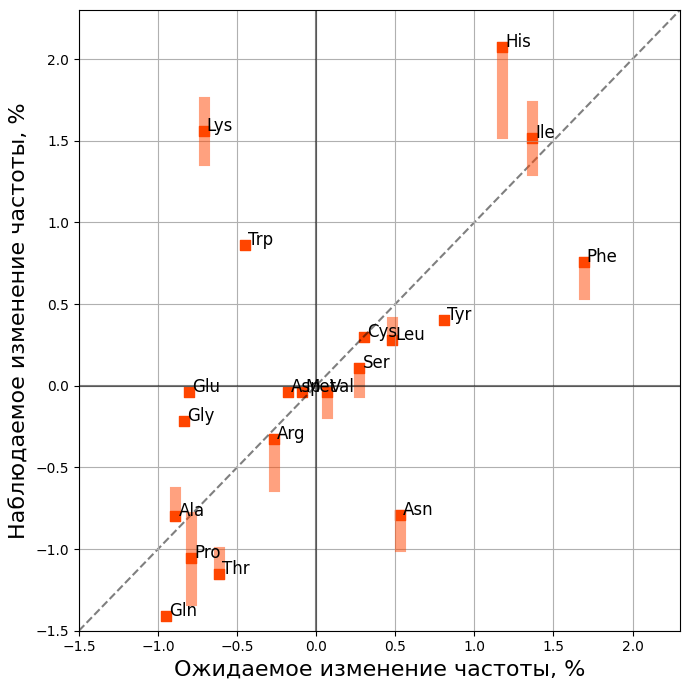

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

for aa, gr in quantiles.groupby('aa'):
    eq1, eq2, eq3 = gr['PE_exp'].values
    oq1, oq2, oq3 = gr['PE_obs'].values

    # if aa in losers:
    #     color = 'blue'
    # elif aa in gainers:
    #     color = 'red'
    # else:
    #     color = 'gray'
    color = 'orangered'
    plt.plot(gr['PE_exp'], gr['PE_obs'], '-', color=color, label=aa, alpha=0.5, linewidth=8)
    plt.scatter(eq2, oq2,  s=50, marker='s', c=color)
    plt.text(eq2+0.02, oq2, aa, fontsize=12, ha='left', va='baseline')


ax.plot([-1.5, 2.5], [-1.5, 2.5], 'k--', alpha=0.5, zorder=1)
plt.grid()
plt.xlabel('Expected AA frequency change, %', fontsize=15)
plt.ylabel('Observed AA frequency change, %', fontsize=15)
# plt.xlabel('Ожидаемое изменение частоты, %', fontsize=15)
# plt.ylabel('Наблюдаемое изменение частоты, %', fontsize=15)
ybound = ax.get_ylim()
xbound = ax.get_xlim()
ybound = [-1.5, 2.3]
xbound = [-1.5, 2.3]
plt.vlines(0, *ybound, color='k', alpha=0.5)
plt.hlines(0, *xbound, color='k', alpha=0.5)
ax.set_xlim(xbound)
ax.set_ylim(ybound)
plt.tight_layout()
plt.savefig('./figures/aa_freqs_change_sim.pdf', bbox_inches='tight')
plt.show()

Text(0.5, 0, 'shapiro p-val')

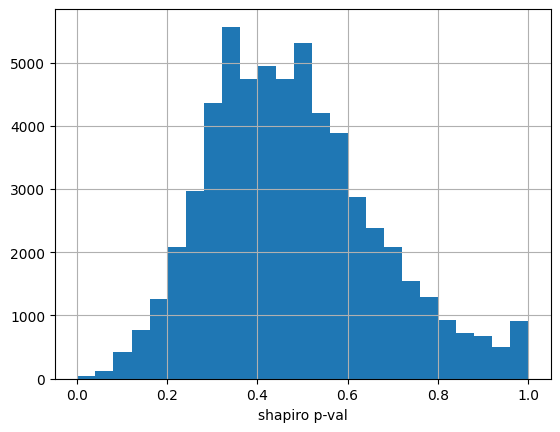

In [33]:
normality = df_change_total.groupby('Accession ID').apply(lambda x: shapiro(x['PE_obs'])[1])
normality.hist(bins=25)
plt.xlabel('shapiro p-val')

np.float64(0.5691706163636756)

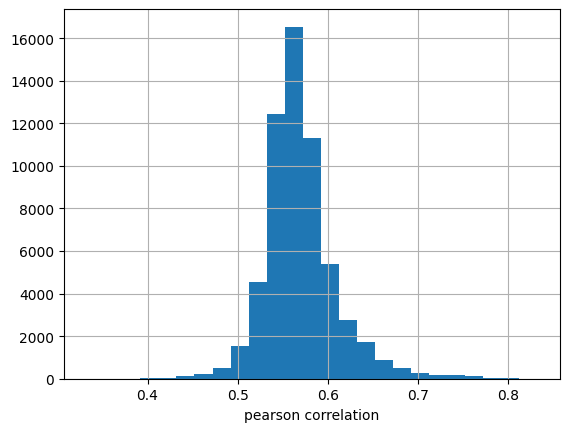

In [34]:
correlation = df_change_total.groupby('Accession ID')\
    .apply(lambda x: pearsonr(x['PE_obs'], x['PE_exp']))

correlation.apply(lambda x: x[0]).hist(bins=25)
plt.xlabel('pearson correlation')
correlation.apply(lambda x: x[0]).mean()

np.float64(0.010238786851872192)

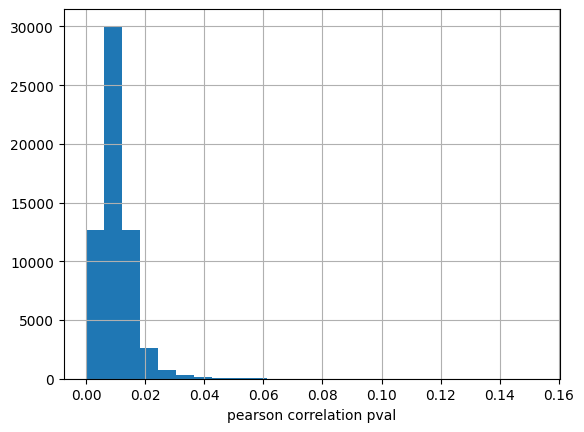

In [127]:
correlation.apply(lambda x: x[1]).hist(bins=25)
plt.xlabel('pearson correlation pval')
correlation.apply(lambda x: x[1]).mean()

## compare simulation equilibrium with true one

Just QC of method

1. eig vec of aa
2. eig vec of cdn
3. sim of aa
4. sim of cdn

In [ ]:
def main_test():
    # 1. Setup Data
    np.random.seed(42)
    n_aa = 20 # Amino acids
    Q = get_random_rate_matrix(n_aa)
    
    # Initial state: 100% start at Amino Acid 0 (e.g., Alanine)
    pi_0 = np.zeros(n_aa)
    pi_0[0] = 1.0
    
    # Increased time to ensure we reach equilibrium for visual comparison
    T_max = 20.0 
    
    # 2. Run Simulations
    
    # Run Exact Method
    t_exact, res_exact = simulate_exact_method(Q, pi_0, T_max, steps=100)
    
    # Run Euler Method (Small step)
    dt_small = 0.01
    t_euler, res_euler = simulate_euler_method(Q, pi_0, T_max, dt_small)
    
    # 3. Calculate Equilibrium using Eigenvector approach
    pi_eq = get_equilibrium_probabilities(Q)

    # 4. Visualization
    plt.figure(figsize=(12, 6))
    
    colors = ['r', 'g', 'b', 'orange', 'k']
    labels = ['AA 1', 'AA 2', 'AA 3', 'AA 4', 'AA 5']
    
    for i in range(3):
        # Plot Exact Simulation Trajectory
        plt.plot(t_exact, res_exact[:, i], color=colors[i], linewidth=2, 
                 label=f'Simulation {labels[i]}' if i==0 else None)
        
        # Plot Equilibrium Target (Eigenvector)
        plt.axhline(y=pi_eq[i], color=colors[i], linestyle='--', alpha=0.5,
                    label=f'Equilibrium {labels[i]}' if i==0 else None)

    plt.title('Convergence to Equilibrium: Simulation vs Eigenvector Analysis')
    plt.xlabel('Evolutionary Time (t)')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('comparison_plot.png')
    print("Simulation complete. Comparison plot generated.")

    # 5. Numerical Comparison
    pi_final_sim = res_exact[-1]
    
    print("\n--- Equilibrium Comparison ---")
    print(f"{'Amino Acid':<12} {'Simulation (t=20)':<20} {'Eigenvector':<20} {'Difference'}")
    print("-" * 65)
    for i in range(20): # Show first 5 AAs
        diff = abs(pi_final_sim[i] - pi_eq[i])
        print(f"AA {i:<9} {pi_final_sim[i]:.6f}             {pi_eq[i]:.6f}             {diff:.2e}")
        
    total_diff = np.linalg.norm(pi_final_sim - pi_eq)
    print("-" * 65)
    print(f"Total Euclidean Distance (Norm) between vectors: {total_diff:.2e}")

# main()

Simulation complete. Comparison plot generated.

--- Equilibrium Comparison ---
Amino Acid   Simulation           EigenvectorAA        Difference
-----------------------------------------------------------------
Ala          0.006170             0.006208             3.82e-05
Arg          0.009977             0.009832             1.45e-04
Asn          0.032000             0.031076             9.24e-04
Asp          0.009674             0.009268             4.06e-04
Cys          0.028309             0.027405             9.05e-04
Gln          0.002774             0.002743             3.13e-05
Glu          0.001823             0.001784             3.86e-05
Gly          0.004315             0.004268             4.75e-05
His          0.019080             0.018166             9.14e-04
Ile          0.114441             0.115340             8.99e-04
Leu          0.203697             0.206272             2.58e-03
Lys          0.005523             0.005428             9.55e-05
Met          0.01465

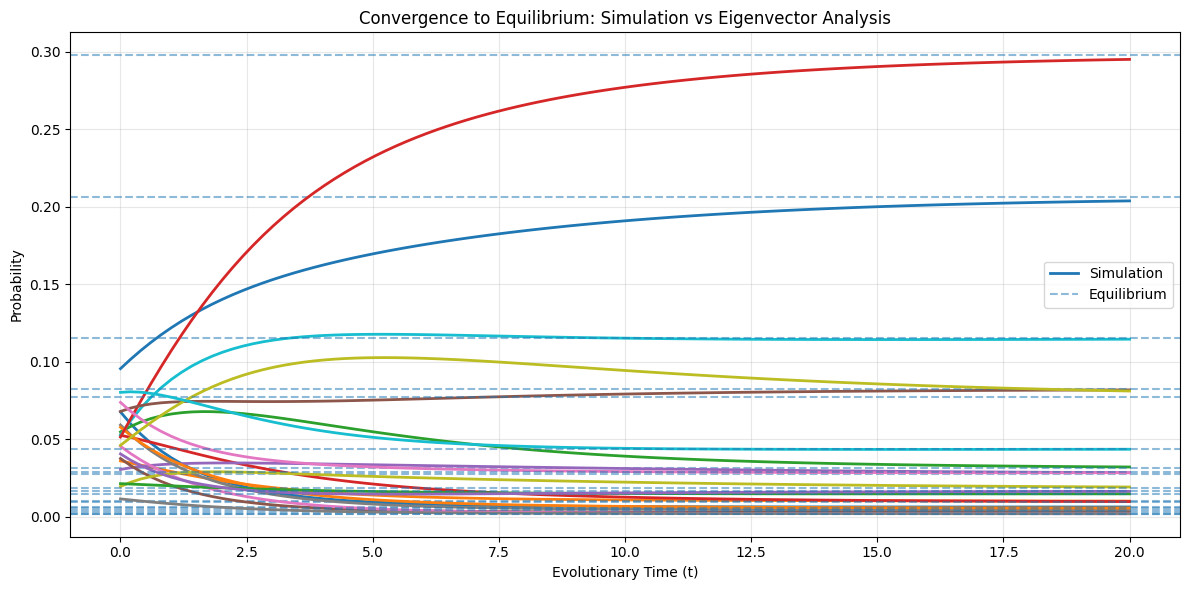

In [88]:
def main():
    # 1. Setup Data
    Q = Maa.copy()
    Q = Q - np.diag(np.sum(Q, axis=1))
    
    # Initial state
    pi_0 = aa_init_freqs
    
    # Increased time to ensure we reach equilibrium for visual comparison
    T_max = 20.0 
    
    # 2. Run Simulations
    
    # Run Exact Method
    t_exact, res_exact = simulate_exact_method(Q, pi_0, T_max, steps=100)
    
    # 3. Calculate Equilibrium using Eigenvector approach
    pi_eq_aa_based = get_equilibrium_probabilities(Maa.values) # amino acid matrix
    
    pi_eq_cdn_based = get_equilibrium_freqs(spectrum_20A, 'rate')[1].set_index('aa')['eq_freq'] # cdn matrix
    pi_eq_cdn_based = np.array([pi_eq_cdn_based[aa] for aa in Maa.columns])

    # for plots
    pi_eq = pi_eq_aa_based

    # 4. Visualization
    plt.figure(figsize=(12, 6))
        
    for i in range(20):
        # Plot Exact Simulation Trajectory
        plt.plot(t_exact, res_exact[:, i], linewidth=2, 
                 label=f'Simulation' if i==0 else None)
        
        # Plot Equilibrium Target (Eigenvector)
        plt.axhline(y=pi_eq[i], linestyle='--', alpha=0.5,
                    label=f'Equilibrium' if i==0 else None)

    plt.title('Convergence to Equilibrium: Simulation vs Eigenvector Analysis')
    plt.xlabel('Evolutionary Time (t)')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('comparison_plot.png')
    print("Simulation complete. Comparison plot generated.")

    # 5. Numerical Comparison
    pi_final_sim = res_exact[-1]
    
    print("\n--- Equilibrium Comparison ---")
    print(f"{'Amino Acid':<12} {'Simulation ':<20} {'EigenvectorAA':<20} {'Difference'}")
    print("-" * 65)
    for i in range(20): # Show first 5 AAs
        diff = abs(pi_final_sim[i] - pi_eq[i])
        print(f"{Maa.columns[i]:<12} {pi_final_sim[i]:.6f}             {pi_eq[i]:.6f}             {diff:.2e}")
    
    print("-" * 65)
    # calc euclidean distance
    print(f"AaEigen vs Sim EucDist: {np.linalg.norm(pi_final_sim - pi_eq_aa_based):.2e} --> Q for simulation was AA-based")
    print(f"CdnEigen vs Sim EucDist: {np.linalg.norm(pi_final_sim - pi_eq_cdn_based):.2e} --> one order more error")
    print(f"AaEigen vs CdnEigen EucDist: {np.linalg.norm(pi_eq_aa_based - pi_eq_cdn_based):.2e} --> Stop-codons have low impact (~5%)")

main()

In [89]:
# 3. Calculate Equilibrium using Eigenvector approach
pi_eq_aa_based = get_equilibrium_probabilities(Maa.values) # amino acid matrix

pi_eq_cdn_based = get_equilibrium_freqs(spectrum_20A, 'rate')[1].set_index('aa')['eq_freq'] # cdn matrix
pi_eq_cdn_based = np.array([pi_eq_cdn_based[aa] for aa in Maa.columns])

In [101]:
np.abs(pi_eq_aa_based - pi_eq_cdn_based)

array([0.00091855, 0.00068977, 0.01387724, 0.00125619, 0.00787792,
       0.00233064, 0.00023072, 0.00142427, 0.00201702, 0.02844216,
       0.00844694, 0.00075036, 0.00789131, 0.01696905, 0.00139679,
       0.03708825, 0.00319652, 0.00016309, 0.00340421, 0.00038695])

In [110]:
np.abs(pi_eq_aa_based - pi_eq_cdn_based).mean()

np.float64(0.006937899343349955)